# Variational AutoEncoder Code
This notebook is an implementation of a variational auto-encoder which was taken from https://blog.lancedb.com/training-a-variational-autoencoder-from-scratch-with-the-lance-file-format/


In [54]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import io

from PIL import Image
from tqdm import tqdm


from matplotlib import pyplot as plt
import numpy as np
import requests
import tarfile
import os
import time

import pyarrow as pa
import lance


### Variational Autoencoder Configuration Breakdown
BATCH_SIZE:
- The number of samples processed together in one forward/backward pass before updating weights

IN_RESOLUTION:
- Input image resolution (width & height)

IN_CHANNELS: 
- Number of channels in the input
-- For RGB images->3 channels
-- For greyscale->1 channel

NUM_EPOCHS:
- Number of full passes through the dataset during training
- Higher epoch -> more opportunities for the model to converge

LEARNING_RATE: 
- Step size used by the optimiser to adjust wieghts
- Smaller -> more stable training but slower
- Larger -> faster, but may overshoot

HIDDEN_DIMS: 
- Defines the number of feature maps in each convolutional layer of the encoder/decoder
- Controls capacity & compression power. eg:
Layer 1: 64 filters
Layer 2: 128 filters
Layer 3: 256 filters
Layer 4: 512 filters

LATENT_DIM_SIZE: 
- Size of the latent space (bottleneck vector)
- size may depend on the image training data size

In [55]:
training_filepath = "cat-spectrograms-1/cat-spectrograms-1_train.lance/"

vae_config = {
    "BATCH_SIZE": 40,
    "IN_RESOLUTION": 256,
    "IN_CHANNELS": 3,
    "NUM_EPOCHS": 300,
    "LEARNING_RATE": 1e-4,
    "HIDDEN_DIMS":[256, 512, 1024, 2048],
    "LATENT_DIM_SIZE": 256,
}

### Utility function to visualise generated data.

In [70]:
def draw_image_grid(samples, save_image = False, path = None, outfile_name = "out", epoch = None):
    images = samples[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    if save_image and path is not None:
        filename = outfile_name + "_epoch_" + str(epoch) + ".png" if epoch is not None else outfile_name + ".png"
        full_path = os.path.join(path, filename)
        # Create the directory if it doesn't exist
        os.makedirs(path, exist_ok=True)

        # Save the figure to the specified path and name
        plt.savefig(full_path, dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()



def draw_image(samples, save_image = False, path = None, outfile_name = "out", epoch = None):
# Select the first image (or any index you want)
    image = samples[0]

    # Unnormalize from [-1, 1] to [0, 1]
    image = (image * 0.5) + 0.5

    # Convert tensor to numpy and permute from (C, H, W) → (H, W, C)
    image = image.permute(1, 2, 0).detach().cpu().numpy()

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    
    if save_image and path is not None:
        filename = outfile_name + "_epoch_" + str(epoch) + ".png" if epoch is not None else outfile_name + ".png"
        full_path = os.path.join(path, filename)
        # Create the directory if it doesn't exist
        os.makedirs(path, exist_ok=True)

        # Save the figure to the specified path and name
        plt.savefig(full_path, dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

def plot_loss(loss_array):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_array, label='Loss')
    plt.grid()
    plt.xlim([0, vae_config["NUM_EPOCHS"]-1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')


def plot_loss_multiple(loss_arrays, labels):
    plt.figure(figsize=(10, 5))
    for loss_array, label in zip(loss_arrays, labels):
        plt.plot(loss_array, label=label)
    plt.grid()
    plt.yscale('log')
    plt.xlim([0, vae_config["NUM_EPOCHS"]-1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

def save_loss_array(loss_array, folder="output_data", filename="loss_array.npy"):
    # Create the directory if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    file_path = os.path.join(folder, filename)
    np.save(file_path, loss_array)

In [57]:
class CustomImageDataset(data.Dataset):
    def __init__(self, classes, lance_dataset, transform=None):
        self.classes = classes
        self.ds = lance.dataset(lance_dataset)
        self.transform = transform

    def __len__(self):
        return self.ds.count_rows()

    def __getitem__(self, idx):
        raw_data = self.ds.take([idx], columns=['image', 'label']).to_pydict()
        img_data, label = raw_data['image'][0], raw_data['label'][0]

        img = Image.open(io.BytesIO(img_data))

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.classes.index(label)
        return img, label

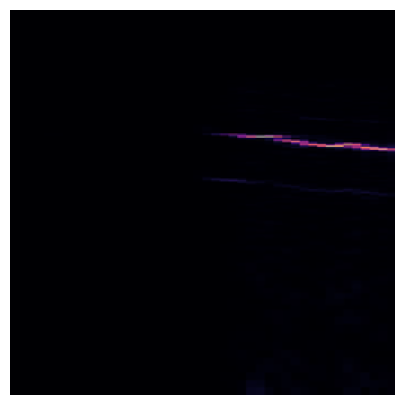

In [58]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # -1 to 1
    ]
)
classes = ('cat')

lance_train_dataset = CustomImageDataset(
    classes,
    #UPDATE PATH BASED ON DATASET
    training_filepath,
    transform=train_transform
)

lance_train_loader = torch.utils.data.DataLoader(
    lance_train_dataset,
    batch_size=vae_config["BATCH_SIZE"],
    shuffle=True
)

train_image, _ = next(iter(lance_train_loader))
draw_image(train_image, save_image = True, path = "training_images", outfile_name = "spec_1_reference")

### VAE Class Defintion 

In [59]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(vae_config["IN_CHANNELS"], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*32*32, vae_config["LATENT_DIM_SIZE"])
        self.fc_logvar = nn.Linear(128*32*32, vae_config["LATENT_DIM_SIZE"])

        # Decoder
        self.decoder_input = nn.Linear(vae_config["LATENT_DIM_SIZE"], 128*32*32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, vae_config["IN_CHANNELS"], kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # change forward - add noise
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 32, 32)
        return self.decoder(z), mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, vae_config["LATENT_DIM_SIZE"]).to(device)
        return self.decoder(self.decoder_input(z).view(-1, 128, 32, 32))

### Training the data

In [60]:
device = "cpu" #change to "cuda" if you have an NVIDIA CPU

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    # change input
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=vae_config["LEARNING_RATE"])
# Define loss array and reference image to see reconstruction quality
loss_array = np.array([])


Epoch 1/300: 100%|██████████| 8/8 [00:20<00:00,  2.59s/it, Loss=4.52e+6]


Epoch [1/300] Average Loss: 175838.1445


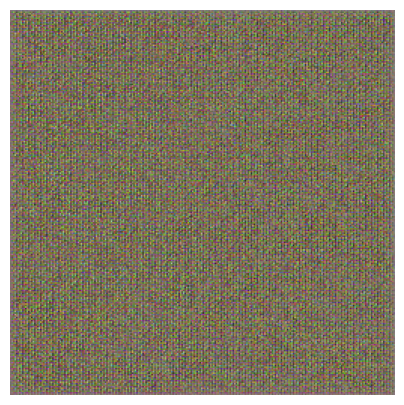

Epoch 2/300: 100%|██████████| 8/8 [00:19<00:00,  2.44s/it, Loss=2.94e+6]


Epoch [2/300] Average Loss: 132053.5130


Epoch 3/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=1.28e+6]


Epoch [3/300] Average Loss: 71702.0349


Epoch 4/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=4.31e+5]


Epoch [4/300] Average Loss: 26352.7579


Epoch 5/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=2.21e+5]


Epoch [5/300] Average Loss: 10468.4510


Epoch 6/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=1.58e+5]


Epoch [6/300] Average Loss: 6540.3287


Epoch 7/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=1.27e+5]


Epoch [7/300] Average Loss: 5069.5894


Epoch 8/300: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it, Loss=1.14e+5]


Epoch [8/300] Average Loss: 4311.3674


Epoch 9/300: 100%|██████████| 8/8 [00:19<00:00,  2.43s/it, Loss=1.01e+5]


Epoch [9/300] Average Loss: 3846.8891


Epoch 10/300: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it, Loss=9.37e+4]


Epoch [10/300] Average Loss: 3506.5018


Epoch 11/300: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, Loss=85243.0]


Epoch [11/300] Average Loss: 3247.1334


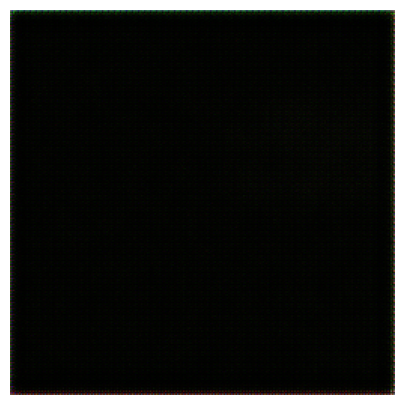

Epoch 12/300: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=7.92e+4]


Epoch [12/300] Average Loss: 3039.1078


Epoch 13/300: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it, Loss=7.58e+4]


Epoch [13/300] Average Loss: 2860.2422


Epoch 14/300: 100%|██████████| 8/8 [00:16<00:00,  2.11s/it, Loss=7.39e+4]


Epoch [14/300] Average Loss: 2701.6958


Epoch 15/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=6.91e+4]


Epoch [15/300] Average Loss: 2560.0157


Epoch 16/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=6.58e+4]


Epoch [16/300] Average Loss: 2437.5294


Epoch 17/300: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, Loss=6.22e+4]


Epoch [17/300] Average Loss: 2326.5363


Epoch 18/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=6.2e+4] 


Epoch [18/300] Average Loss: 2232.8523


Epoch 19/300: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it, Loss=5.89e+4]


Epoch [19/300] Average Loss: 2145.1809


Epoch 20/300: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it, Loss=5.64e+4]


Epoch [20/300] Average Loss: 2071.0793


Epoch 21/300: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it, Loss=5.46e+4]


Epoch [21/300] Average Loss: 1996.5165


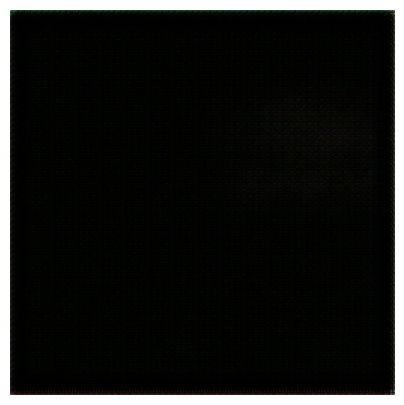

Epoch 22/300: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it, Loss=4.98e+4]


Epoch [22/300] Average Loss: 1932.2511


Epoch 23/300: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it, Loss=5.64e+4]


Epoch [23/300] Average Loss: 1873.9308


Epoch 24/300: 100%|██████████| 8/8 [00:15<00:00,  1.89s/it, Loss=4.82e+4]


Epoch [24/300] Average Loss: 1819.7774


Epoch 25/300: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it, Loss=4.71e+4]


Epoch [25/300] Average Loss: 1776.8007


Epoch 26/300: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it, Loss=4.87e+4]


Epoch [26/300] Average Loss: 1726.6161


Epoch 27/300: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it, Loss=4.95e+4]


Epoch [27/300] Average Loss: 1689.2462


Epoch 28/300: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it, Loss=4.75e+4]


Epoch [28/300] Average Loss: 1648.3187


Epoch 29/300: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it, Loss=4.27e+4]


Epoch [29/300] Average Loss: 1615.0277


Epoch 30/300: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it, Loss=4.01e+4]


Epoch [30/300] Average Loss: 1583.2711


Epoch 31/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=4.16e+4]


Epoch [31/300] Average Loss: 1554.3264


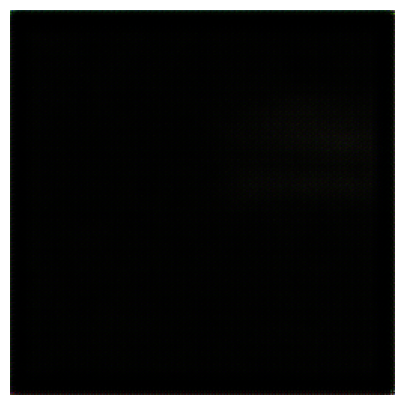

Epoch 32/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=4.18e+4]


Epoch [32/300] Average Loss: 1526.6531


Epoch 33/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=4.06e+4]


Epoch [33/300] Average Loss: 1502.3393


Epoch 34/300: 100%|██████████| 8/8 [00:17<00:00,  2.18s/it, Loss=4.63e+4]


Epoch [34/300] Average Loss: 1475.8420


Epoch 35/300: 100%|██████████| 8/8 [00:18<00:00,  2.32s/it, Loss=3.79e+4]


Epoch [35/300] Average Loss: 1453.5229


Epoch 36/300: 100%|██████████| 8/8 [00:17<00:00,  2.20s/it, Loss=4.09e+4]


Epoch [36/300] Average Loss: 1428.6929


Epoch 37/300: 100%|██████████| 8/8 [00:17<00:00,  2.23s/it, Loss=3.9e+4] 


Epoch [37/300] Average Loss: 1413.7662


Epoch 38/300: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it, Loss=3.93e+4]


Epoch [38/300] Average Loss: 1393.3572


Epoch 39/300: 100%|██████████| 8/8 [00:22<00:00,  2.85s/it, Loss=3.86e+4]


Epoch [39/300] Average Loss: 1377.4152


Epoch 40/300: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it, Loss=3.94e+4]


Epoch [40/300] Average Loss: 1359.7718


Epoch 41/300: 100%|██████████| 8/8 [00:21<00:00,  2.68s/it, Loss=3.82e+4]


Epoch [41/300] Average Loss: 1342.2886


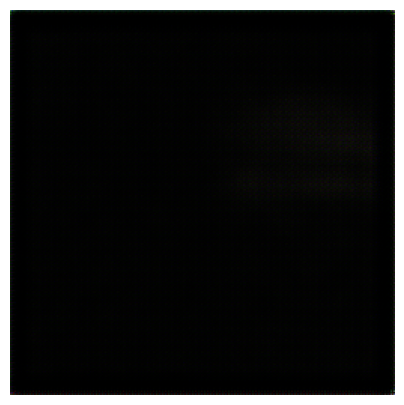

Epoch 42/300: 100%|██████████| 8/8 [00:19<00:00,  2.39s/it, Loss=3.62e+4]


Epoch [42/300] Average Loss: 1326.7607


Epoch 43/300: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it, Loss=3.96e+4]


Epoch [43/300] Average Loss: 1312.2844


Epoch 44/300: 100%|██████████| 8/8 [00:20<00:00,  2.52s/it, Loss=3.61e+4]


Epoch [44/300] Average Loss: 1298.7178


Epoch 45/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=3.47e+4]


Epoch [45/300] Average Loss: 1285.7841


Epoch 46/300: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=3.7e+4] 


Epoch [46/300] Average Loss: 1270.7602


Epoch 47/300: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=3.23e+4]


Epoch [47/300] Average Loss: 1259.5523


Epoch 48/300: 100%|██████████| 8/8 [00:19<00:00,  2.42s/it, Loss=3.19e+4]


Epoch [48/300] Average Loss: 1250.3455


Epoch 49/300: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=3.28e+4]


Epoch [49/300] Average Loss: 1235.7289


Epoch 50/300: 100%|██████████| 8/8 [00:19<00:00,  2.38s/it, Loss=3.44e+4]


Epoch [50/300] Average Loss: 1227.0382


Epoch 51/300: 100%|██████████| 8/8 [00:19<00:00,  2.47s/it, Loss=3.08e+4]


Epoch [51/300] Average Loss: 1214.2812


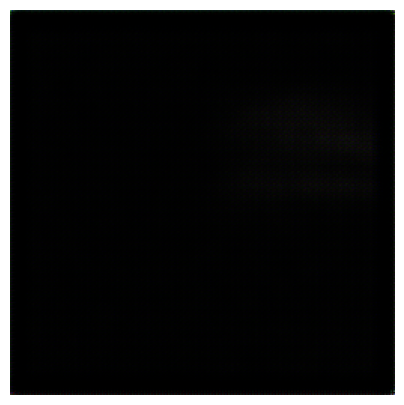

Epoch 52/300: 100%|██████████| 8/8 [00:19<00:00,  2.46s/it, Loss=3.33e+4]


Epoch [52/300] Average Loss: 1208.1799


Epoch 53/300: 100%|██████████| 8/8 [00:19<00:00,  2.48s/it, Loss=3.72e+4]


Epoch [53/300] Average Loss: 1195.4889


Epoch 54/300: 100%|██████████| 8/8 [00:19<00:00,  2.45s/it, Loss=3.15e+4]


Epoch [54/300] Average Loss: 1189.2876


Epoch 55/300: 100%|██████████| 8/8 [00:19<00:00,  2.43s/it, Loss=3.12e+4]


Epoch [55/300] Average Loss: 1176.9621


Epoch 56/300: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it, Loss=3.03e+4]


Epoch [56/300] Average Loss: 1171.4555


Epoch 57/300: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, Loss=2.97e+4]


Epoch [57/300] Average Loss: 1161.1566


Epoch 58/300: 100%|██████████| 8/8 [00:18<00:00,  2.35s/it, Loss=2.97e+4]


Epoch [58/300] Average Loss: 1151.6549


Epoch 59/300: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=3.15e+4]


Epoch [59/300] Average Loss: 1143.8737


Epoch 60/300: 100%|██████████| 8/8 [00:18<00:00,  2.37s/it, Loss=3.21e+4]


Epoch [60/300] Average Loss: 1136.9218


Epoch 61/300: 100%|██████████| 8/8 [00:19<00:00,  2.41s/it, Loss=3.14e+4]


Epoch [61/300] Average Loss: 1127.6027


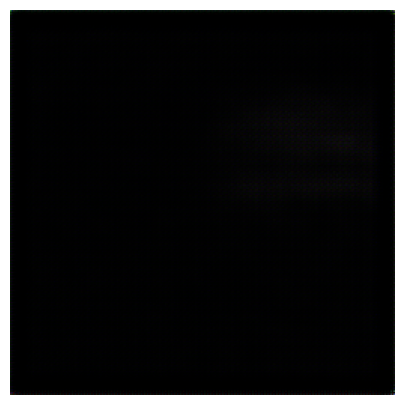

Epoch 62/300: 100%|██████████| 8/8 [00:19<00:00,  2.40s/it, Loss=3.39e+4]


Epoch [62/300] Average Loss: 1120.9852


Epoch 63/300: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=3.13e+4]


Epoch [63/300] Average Loss: 1116.4501


Epoch 64/300: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=3.24e+4]


Epoch [64/300] Average Loss: 1109.7737


Epoch 65/300: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=2.77e+4]


Epoch [65/300] Average Loss: 1102.4684


Epoch 66/300: 100%|██████████| 8/8 [00:18<00:00,  2.25s/it, Loss=2.99e+4]


Epoch [66/300] Average Loss: 1095.3366


Epoch 67/300: 100%|██████████| 8/8 [00:17<00:00,  2.14s/it, Loss=2.9e+4] 


Epoch [67/300] Average Loss: 1089.9666


Epoch 68/300: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it, Loss=2.96e+4]


Epoch [68/300] Average Loss: 1084.2399


Epoch 69/300: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=2.83e+4]


Epoch [69/300] Average Loss: 1077.2480


Epoch 70/300: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it, Loss=2.79e+4]


Epoch [70/300] Average Loss: 1070.7135


Epoch 71/300: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it, Loss=3e+4]   


Epoch [71/300] Average Loss: 1066.9091


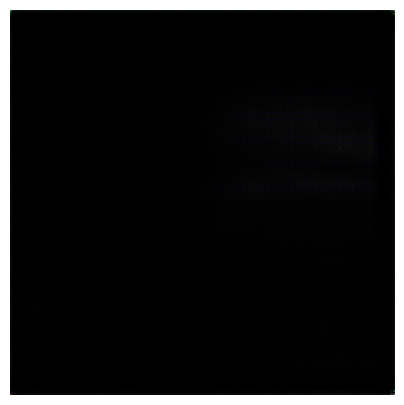

Epoch 72/300: 100%|██████████| 8/8 [00:16<00:00,  2.10s/it, Loss=2.83e+4]


Epoch [72/300] Average Loss: 1057.9504


Epoch 73/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.91e+4]


Epoch [73/300] Average Loss: 1052.9178


Epoch 74/300: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it, Loss=3.14e+4]


Epoch [74/300] Average Loss: 1049.2156


Epoch 75/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=3.13e+4]


Epoch [75/300] Average Loss: 1044.2131


Epoch 76/300: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it, Loss=2.86e+4]


Epoch [76/300] Average Loss: 1042.2945


Epoch 77/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.91e+4]


Epoch [77/300] Average Loss: 1039.0514


Epoch 78/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.89e+4]


Epoch [78/300] Average Loss: 1038.8417


Epoch 79/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.78e+4]


Epoch [79/300] Average Loss: 1024.6591


Epoch 80/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=3.24e+4]


Epoch [80/300] Average Loss: 1019.8270


Epoch 81/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.66e+4]


Epoch [81/300] Average Loss: 1012.6934


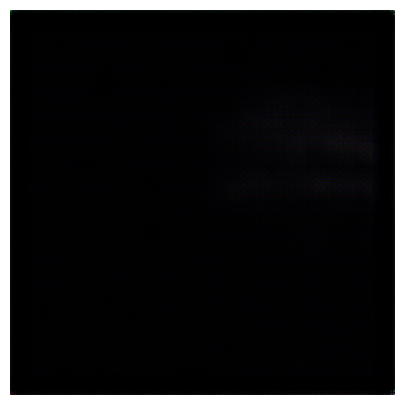

Epoch 82/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.83e+4]


Epoch [82/300] Average Loss: 1007.3367


Epoch 83/300: 100%|██████████| 8/8 [00:16<00:00,  2.05s/it, Loss=2.55e+4]


Epoch [83/300] Average Loss: 1002.2134


Epoch 84/300: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, Loss=2.67e+4]


Epoch [84/300] Average Loss: 997.9201


Epoch 85/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.79e+4]


Epoch [85/300] Average Loss: 992.0094


Epoch 86/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.55e+4]


Epoch [86/300] Average Loss: 988.8575


Epoch 87/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.56e+4]


Epoch [87/300] Average Loss: 986.8343


Epoch 88/300: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, Loss=2.9e+4] 


Epoch [88/300] Average Loss: 982.2082


Epoch 89/300: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it, Loss=2.53e+4]


Epoch [89/300] Average Loss: 977.3390


Epoch 90/300: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, Loss=2.42e+4]


Epoch [90/300] Average Loss: 974.0926


Epoch 91/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.91e+4]


Epoch [91/300] Average Loss: 969.3335


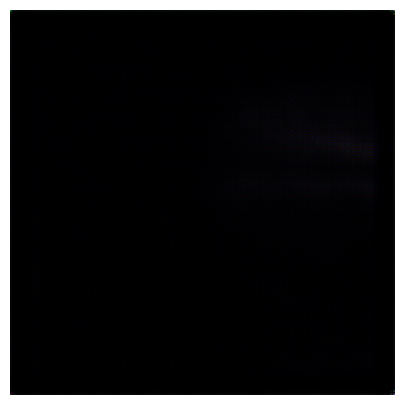

Epoch 92/300: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it, Loss=3.12e+4]


Epoch [92/300] Average Loss: 966.8137


Epoch 93/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.38e+4]


Epoch [93/300] Average Loss: 963.1709


Epoch 94/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.63e+4]


Epoch [94/300] Average Loss: 954.3981


Epoch 95/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.35e+4]


Epoch [95/300] Average Loss: 951.8434


Epoch 96/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.74e+4]


Epoch [96/300] Average Loss: 952.8889


Epoch 97/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.36e+4]


Epoch [97/300] Average Loss: 946.8217


Epoch 98/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.45e+4]


Epoch [98/300] Average Loss: 943.1606


Epoch 99/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.45e+4]


Epoch [99/300] Average Loss: 939.3562


Epoch 100/300: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it, Loss=2.55e+4]


Epoch [100/300] Average Loss: 937.0083


Epoch 101/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.72e+4]


Epoch [101/300] Average Loss: 934.4029


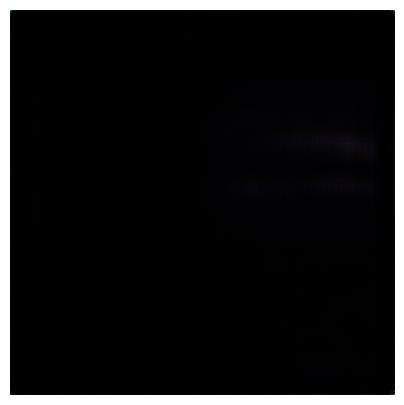

Epoch 102/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.47e+4]


Epoch [102/300] Average Loss: 939.7850


Epoch 103/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.25e+4]


Epoch [103/300] Average Loss: 930.4280


Epoch 104/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.31e+4]


Epoch [104/300] Average Loss: 927.0851


Epoch 105/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.78e+4]


Epoch [105/300] Average Loss: 919.3949


Epoch 106/300: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it, Loss=3.1e+4] 


Epoch [106/300] Average Loss: 921.9697


Epoch 107/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.69e+4]


Epoch [107/300] Average Loss: 914.8160


Epoch 108/300: 100%|██████████| 8/8 [00:15<00:00,  2.00s/it, Loss=2.51e+4]


Epoch [108/300] Average Loss: 913.5480


Epoch 109/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.75e+4]


Epoch [109/300] Average Loss: 908.8614


Epoch 110/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.6e+4] 


Epoch [110/300] Average Loss: 908.1683


Epoch 111/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.32e+4]


Epoch [111/300] Average Loss: 901.2541


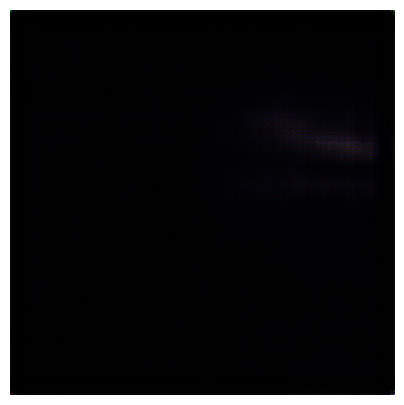

Epoch 112/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.52e+4]


Epoch [112/300] Average Loss: 901.2266


Epoch 113/300: 100%|██████████| 8/8 [00:15<00:00,  2.00s/it, Loss=2.43e+4]


Epoch [113/300] Average Loss: 901.4133


Epoch 114/300: 100%|██████████| 8/8 [00:16<00:00,  2.00s/it, Loss=2.85e+4]


Epoch [114/300] Average Loss: 893.8636


Epoch 115/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.45e+4]


Epoch [115/300] Average Loss: 893.5785


Epoch 116/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.61e+4]


Epoch [116/300] Average Loss: 889.7585


Epoch 117/300: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it, Loss=2.74e+4]


Epoch [117/300] Average Loss: 884.9991


Epoch 118/300: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it, Loss=2.51e+4]


Epoch [118/300] Average Loss: 890.1472


Epoch 119/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.3e+4] 


Epoch [119/300] Average Loss: 885.2697


Epoch 120/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.83e+4]


Epoch [120/300] Average Loss: 878.7520


Epoch 121/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.36e+4]


Epoch [121/300] Average Loss: 874.2406


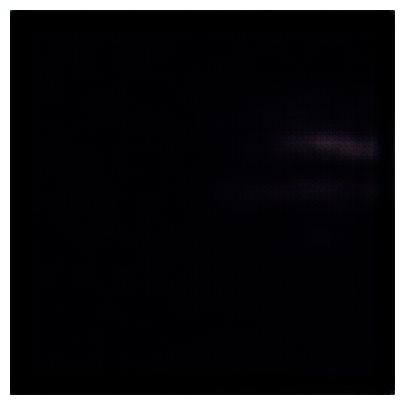

Epoch 122/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.6e+4] 


Epoch [122/300] Average Loss: 870.6740


Epoch 123/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.47e+4]


Epoch [123/300] Average Loss: 873.0688


Epoch 124/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.27e+4]


Epoch [124/300] Average Loss: 868.7603


Epoch 125/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.44e+4]


Epoch [125/300] Average Loss: 865.2641


Epoch 126/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.13e+4]


Epoch [126/300] Average Loss: 863.0553


Epoch 127/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.45e+4]


Epoch [127/300] Average Loss: 857.3470


Epoch 128/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.52e+4]


Epoch [128/300] Average Loss: 855.6664


Epoch 129/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.18e+4]


Epoch [129/300] Average Loss: 856.5457


Epoch 130/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.34e+4]


Epoch [130/300] Average Loss: 853.9660


Epoch 131/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.61e+4]


Epoch [131/300] Average Loss: 868.0285


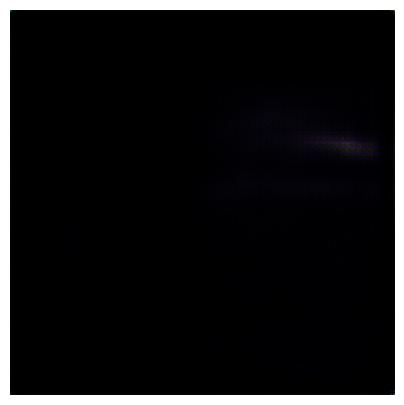

Epoch 132/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.27e+4]


Epoch [132/300] Average Loss: 857.4984


Epoch 133/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.28e+4]


Epoch [133/300] Average Loss: 853.8806


Epoch 134/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.13e+4]


Epoch [134/300] Average Loss: 842.4807


Epoch 135/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.38e+4]


Epoch [135/300] Average Loss: 840.3848


Epoch 136/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.01e+4]


Epoch [136/300] Average Loss: 840.4770


Epoch 137/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.03e+4]


Epoch [137/300] Average Loss: 835.8473


Epoch 138/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.48e+4]


Epoch [138/300] Average Loss: 840.7026


Epoch 139/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.37e+4]


Epoch [139/300] Average Loss: 837.0551


Epoch 140/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.3e+4] 


Epoch [140/300] Average Loss: 831.4301


Epoch 141/300: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it, Loss=2.63e+4]


Epoch [141/300] Average Loss: 832.2373


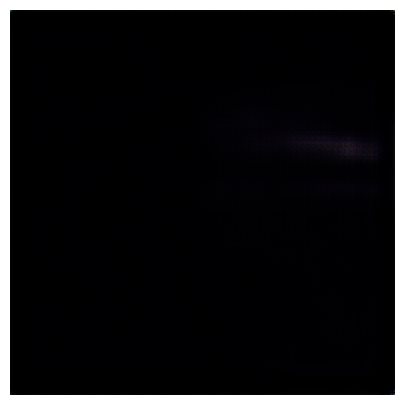

Epoch 142/300: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=2.16e+4]


Epoch [142/300] Average Loss: 827.3641


Epoch 143/300: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it, Loss=2.47e+4]


Epoch [143/300] Average Loss: 836.5435


Epoch 144/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.31e+4]


Epoch [144/300] Average Loss: 841.9302


Epoch 145/300: 100%|██████████| 8/8 [00:16<00:00,  2.05s/it, Loss=2.36e+4]


Epoch [145/300] Average Loss: 832.2686


Epoch 146/300: 100%|██████████| 8/8 [00:16<00:00,  2.09s/it, Loss=2.47e+4]


Epoch [146/300] Average Loss: 823.4539


Epoch 147/300: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it, Loss=2.61e+4]


Epoch [147/300] Average Loss: 818.7332


Epoch 148/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.32e+4]


Epoch [148/300] Average Loss: 818.4642


Epoch 149/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.34e+4]


Epoch [149/300] Average Loss: 824.2860


Epoch 150/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.42e+4]


Epoch [150/300] Average Loss: 816.6870


Epoch 151/300: 100%|██████████| 8/8 [00:16<00:00,  2.02s/it, Loss=2.2e+4] 


Epoch [151/300] Average Loss: 818.5612


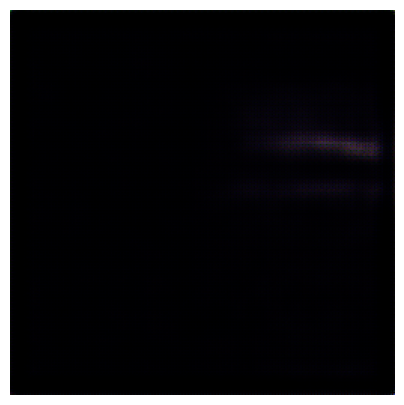

Epoch 152/300: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it, Loss=2.42e+4]


Epoch [152/300] Average Loss: 809.9673


Epoch 153/300: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=2.41e+4]


Epoch [153/300] Average Loss: 809.0874


Epoch 154/300: 100%|██████████| 8/8 [00:16<00:00,  2.07s/it, Loss=2.42e+4]


Epoch [154/300] Average Loss: 810.7030


Epoch 155/300: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it, Loss=2.42e+4]


Epoch [155/300] Average Loss: 808.1495


Epoch 156/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.06e+4]


Epoch [156/300] Average Loss: 804.7298


Epoch 157/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.34e+4]


Epoch [157/300] Average Loss: 802.3999


Epoch 158/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.15e+4]


Epoch [158/300] Average Loss: 802.9702


Epoch 159/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.61e+4]


Epoch [159/300] Average Loss: 808.5644


Epoch 160/300: 100%|██████████| 8/8 [00:16<00:00,  2.03s/it, Loss=2.73e+4]


Epoch [160/300] Average Loss: 806.3462


Epoch 161/300: 100%|██████████| 8/8 [00:16<00:00,  2.05s/it, Loss=2.08e+4]


Epoch [161/300] Average Loss: 802.8291


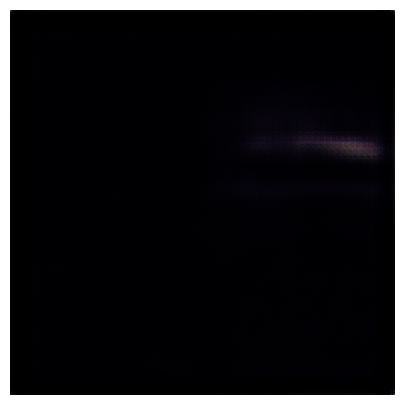

Epoch 162/300: 100%|██████████| 8/8 [00:16<00:00,  2.04s/it, Loss=2.26e+4]


Epoch [162/300] Average Loss: 793.2999


Epoch 163/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.43e+4]


Epoch [163/300] Average Loss: 792.6648


Epoch 164/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.25e+4]


Epoch [164/300] Average Loss: 791.8101


Epoch 165/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.2e+4] 


Epoch [165/300] Average Loss: 794.0277


Epoch 166/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.07e+4]


Epoch [166/300] Average Loss: 787.9600


Epoch 167/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.39e+4]


Epoch [167/300] Average Loss: 788.7881


Epoch 168/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.13e+4]


Epoch [168/300] Average Loss: 787.7004


Epoch 169/300: 100%|██████████| 8/8 [00:15<00:00,  2.00s/it, Loss=1.93e+4]


Epoch [169/300] Average Loss: 788.6199


Epoch 170/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.29e+4]


Epoch [170/300] Average Loss: 789.6121


Epoch 171/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.38e+4]


Epoch [171/300] Average Loss: 790.4558


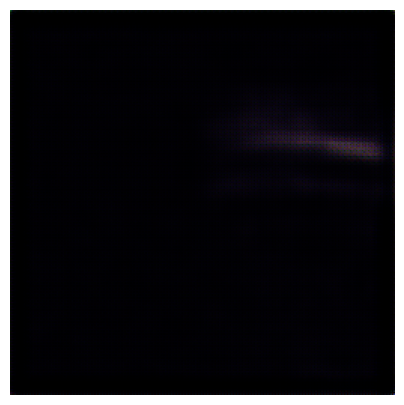

Epoch 172/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.28e+4]


Epoch [172/300] Average Loss: 787.3197


Epoch 173/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.21e+4]


Epoch [173/300] Average Loss: 790.7262


Epoch 174/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.48e+4]


Epoch [174/300] Average Loss: 784.7064


Epoch 175/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.04e+4]


Epoch [175/300] Average Loss: 788.0788


Epoch 176/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.21e+4]


Epoch [176/300] Average Loss: 785.7081


Epoch 177/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.34e+4]


Epoch [177/300] Average Loss: 785.9338


Epoch 178/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2e+4]   


Epoch [178/300] Average Loss: 779.1451


Epoch 179/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.09e+4]


Epoch [179/300] Average Loss: 777.7976


Epoch 180/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.29e+4]


Epoch [180/300] Average Loss: 776.2931


Epoch 181/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.13e+4]


Epoch [181/300] Average Loss: 774.8052


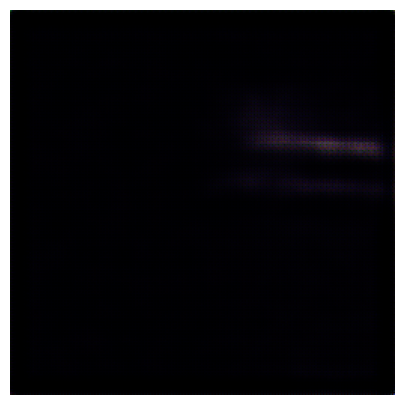

Epoch 182/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.19e+4]


Epoch [182/300] Average Loss: 777.9425


Epoch 183/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.1e+4] 


Epoch [183/300] Average Loss: 768.7842


Epoch 184/300: 100%|██████████| 8/8 [00:16<00:00,  2.09s/it, Loss=2.07e+4]


Epoch [184/300] Average Loss: 766.5104


Epoch 185/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.09e+4]


Epoch [185/300] Average Loss: 768.2068


Epoch 186/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.39e+4]


Epoch [186/300] Average Loss: 766.6922


Epoch 187/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.04e+4]


Epoch [187/300] Average Loss: 762.3062


Epoch 188/300: 100%|██████████| 8/8 [00:16<00:00,  2.01s/it, Loss=2.25e+4]


Epoch [188/300] Average Loss: 762.7336


Epoch 189/300: 100%|██████████| 8/8 [00:16<00:00,  2.06s/it, Loss=2.02e+4]


Epoch [189/300] Average Loss: 769.9925


Epoch 190/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.07e+4]


Epoch [190/300] Average Loss: 765.0842


Epoch 191/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.93e+4]


Epoch [191/300] Average Loss: 764.8659


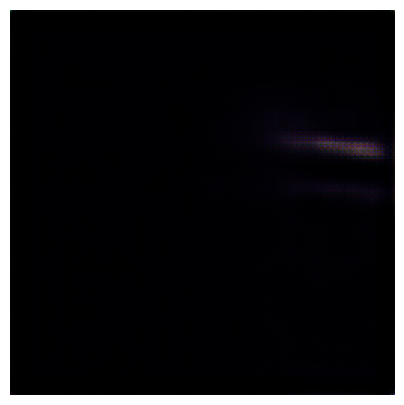

Epoch 192/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.15e+4]


Epoch [192/300] Average Loss: 756.8018


Epoch 193/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.15e+4]


Epoch [193/300] Average Loss: 754.8867


Epoch 194/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.25e+4]


Epoch [194/300] Average Loss: 775.5805


Epoch 195/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.54e+4]


Epoch [195/300] Average Loss: 766.9188


Epoch 196/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=1.77e+4]


Epoch [196/300] Average Loss: 764.4231


Epoch 197/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.28e+4]


Epoch [197/300] Average Loss: 763.0504


Epoch 198/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.42e+4]


Epoch [198/300] Average Loss: 759.9949


Epoch 199/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.98e+4]


Epoch [199/300] Average Loss: 763.7426


Epoch 200/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.01e+4]


Epoch [200/300] Average Loss: 753.0931


Epoch 201/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.9e+4] 


Epoch [201/300] Average Loss: 751.7262


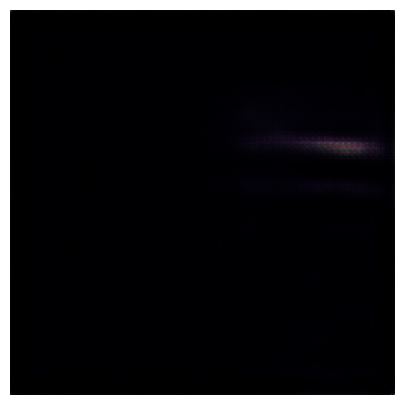

Epoch 202/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.09e+4]


Epoch [202/300] Average Loss: 742.4787


Epoch 203/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.06e+4]


Epoch [203/300] Average Loss: 745.6270


Epoch 204/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.15e+4]


Epoch [204/300] Average Loss: 742.0916


Epoch 205/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2e+4]   


Epoch [205/300] Average Loss: 751.1744


Epoch 206/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=2.23e+4]


Epoch [206/300] Average Loss: 752.4244


Epoch 207/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.06e+4]


Epoch [207/300] Average Loss: 747.9288


Epoch 208/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.88e+4]


Epoch [208/300] Average Loss: 748.2049


Epoch 209/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.06e+4]


Epoch [209/300] Average Loss: 747.4395


Epoch 210/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.05e+4]


Epoch [210/300] Average Loss: 744.7835


Epoch 211/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.19e+4]


Epoch [211/300] Average Loss: 741.1866


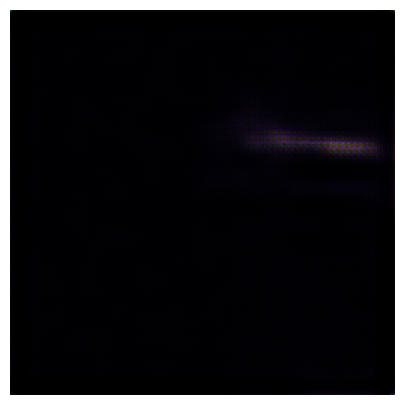

Epoch 212/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.19e+4]


Epoch [212/300] Average Loss: 745.5150


Epoch 213/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.71e+4]


Epoch [213/300] Average Loss: 745.7002


Epoch 214/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.11e+4]


Epoch [214/300] Average Loss: 749.7595


Epoch 215/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.15e+4]


Epoch [215/300] Average Loss: 737.3699


Epoch 216/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.07e+4]


Epoch [216/300] Average Loss: 740.6788


Epoch 217/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.99e+4]


Epoch [217/300] Average Loss: 745.6282


Epoch 218/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.2e+4] 


Epoch [218/300] Average Loss: 746.4853


Epoch 219/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.15e+4]


Epoch [219/300] Average Loss: 744.9238


Epoch 220/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.1e+4] 


Epoch [220/300] Average Loss: 754.2146


Epoch 221/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.17e+4]


Epoch [221/300] Average Loss: 739.4030


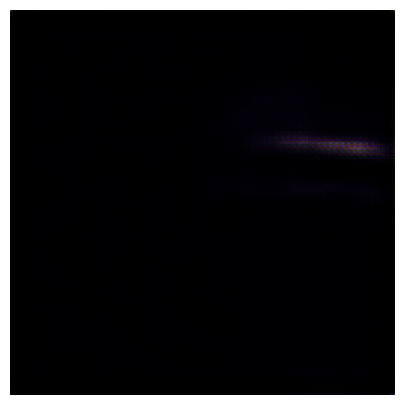

Epoch 222/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.02e+4]


Epoch [222/300] Average Loss: 737.6204


Epoch 223/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.94e+4]


Epoch [223/300] Average Loss: 737.1961


Epoch 224/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2e+4]   


Epoch [224/300] Average Loss: 730.9494


Epoch 225/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=2.25e+4]


Epoch [225/300] Average Loss: 741.7174


Epoch 226/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.77e+4]


Epoch [226/300] Average Loss: 730.3947


Epoch 227/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.26e+4]


Epoch [227/300] Average Loss: 735.6424


Epoch 228/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.9e+4] 


Epoch [228/300] Average Loss: 732.9798


Epoch 229/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.12e+4]


Epoch [229/300] Average Loss: 730.9420


Epoch 230/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.24e+4]


Epoch [230/300] Average Loss: 727.1341


Epoch 231/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.14e+4]


Epoch [231/300] Average Loss: 725.5900


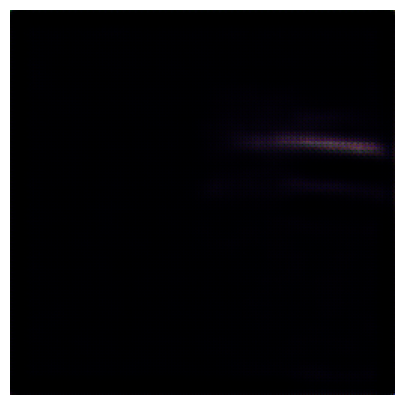

Epoch 232/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=1.85e+4]


Epoch [232/300] Average Loss: 718.6628


Epoch 233/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.15e+4]


Epoch [233/300] Average Loss: 722.5641


Epoch 234/300: 100%|██████████| 8/8 [00:15<00:00,  1.98s/it, Loss=2.06e+4]


Epoch [234/300] Average Loss: 718.5865


Epoch 235/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.09e+4]


Epoch [235/300] Average Loss: 717.8386


Epoch 236/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.04e+4]


Epoch [236/300] Average Loss: 720.4393


Epoch 237/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.13e+4]


Epoch [237/300] Average Loss: 724.1379


Epoch 238/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.01e+4]


Epoch [238/300] Average Loss: 728.8233


Epoch 239/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.33e+4]


Epoch [239/300] Average Loss: 725.4677


Epoch 240/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.07e+4]


Epoch [240/300] Average Loss: 715.8195


Epoch 241/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.08e+4]


Epoch [241/300] Average Loss: 716.2175


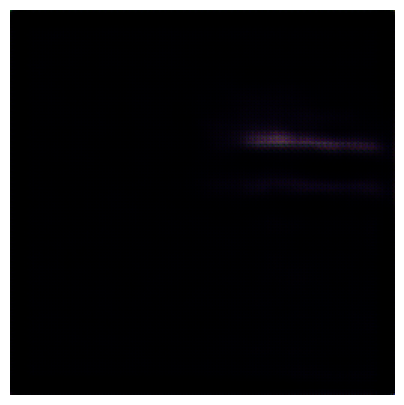

Epoch 242/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.03e+4]


Epoch [242/300] Average Loss: 715.7047


Epoch 243/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=2.13e+4]


Epoch [243/300] Average Loss: 710.4932


Epoch 244/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.96e+4]


Epoch [244/300] Average Loss: 712.1010


Epoch 245/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.87e+4]


Epoch [245/300] Average Loss: 710.5615


Epoch 246/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.11e+4]


Epoch [246/300] Average Loss: 721.4161


Epoch 247/300: 100%|██████████| 8/8 [00:15<00:00,  1.99s/it, Loss=1.98e+4]


Epoch [247/300] Average Loss: 729.8521


Epoch 248/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.91e+4]


Epoch [248/300] Average Loss: 714.2165


Epoch 249/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.01e+4]


Epoch [249/300] Average Loss: 714.2772


Epoch 250/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=2.05e+4]


Epoch [250/300] Average Loss: 710.7482


Epoch 251/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.86e+4]


Epoch [251/300] Average Loss: 710.2784


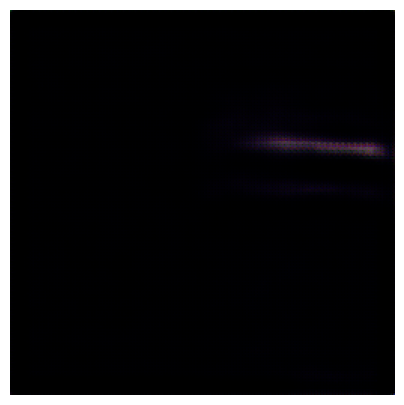

Epoch 252/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.25e+4]


Epoch [252/300] Average Loss: 709.1883


Epoch 253/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.81e+4]


Epoch [253/300] Average Loss: 713.0939


Epoch 254/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.96e+4]


Epoch [254/300] Average Loss: 722.9464


Epoch 255/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.08e+4]


Epoch [255/300] Average Loss: 712.5975


Epoch 256/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.93e+4]


Epoch [256/300] Average Loss: 714.5399


Epoch 257/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.88e+4]


Epoch [257/300] Average Loss: 713.0039


Epoch 258/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.8e+4] 


Epoch [258/300] Average Loss: 708.2555


Epoch 259/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.61e+4]


Epoch [259/300] Average Loss: 702.8103


Epoch 260/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.04e+4]


Epoch [260/300] Average Loss: 703.9349


Epoch 261/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.14e+4]


Epoch [261/300] Average Loss: 702.0892


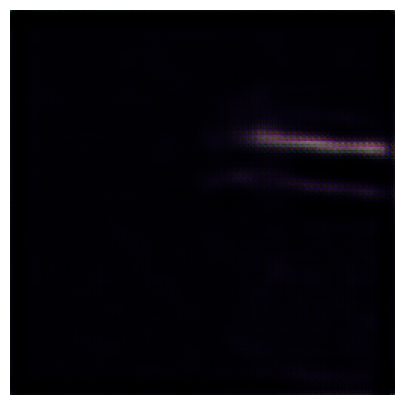

Epoch 262/300: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it, Loss=1.85e+4]


Epoch [262/300] Average Loss: 698.2019


Epoch 263/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.96e+4]


Epoch [263/300] Average Loss: 710.1829


Epoch 264/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.81e+4]


Epoch [264/300] Average Loss: 699.5834


Epoch 265/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.2e+4] 


Epoch [265/300] Average Loss: 701.4615


Epoch 266/300: 100%|██████████| 8/8 [00:15<00:00,  1.93s/it, Loss=1.97e+4]


Epoch [266/300] Average Loss: 692.7220


Epoch 267/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.82e+4]


Epoch [267/300] Average Loss: 698.4251


Epoch 268/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.98e+4]


Epoch [268/300] Average Loss: 698.5433


Epoch 269/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.99e+4]


Epoch [269/300] Average Loss: 694.1132


Epoch 270/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.01e+4]


Epoch [270/300] Average Loss: 688.9435


Epoch 271/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=2.02e+4]


Epoch [271/300] Average Loss: 685.7015


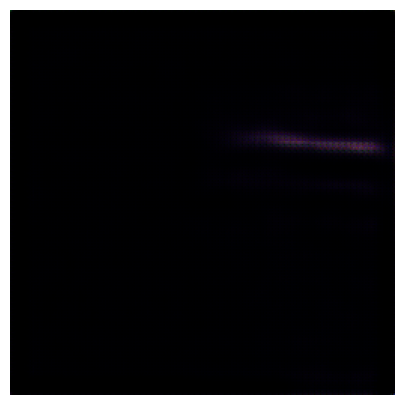

Epoch 272/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.88e+4]


Epoch [272/300] Average Loss: 683.9228


Epoch 273/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.89e+4]


Epoch [273/300] Average Loss: 674.0373


Epoch 274/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.61e+4]


Epoch [274/300] Average Loss: 669.5033


Epoch 275/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.79e+4]


Epoch [275/300] Average Loss: 672.0241


Epoch 276/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.88e+4]


Epoch [276/300] Average Loss: 674.3225


Epoch 277/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.88e+4]


Epoch [277/300] Average Loss: 670.0836


Epoch 278/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.65e+4]


Epoch [278/300] Average Loss: 664.1478


Epoch 279/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.79e+4]


Epoch [279/300] Average Loss: 664.8433


Epoch 280/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=2.08e+4]


Epoch [280/300] Average Loss: 668.2752


Epoch 281/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.09e+4]


Epoch [281/300] Average Loss: 665.8435


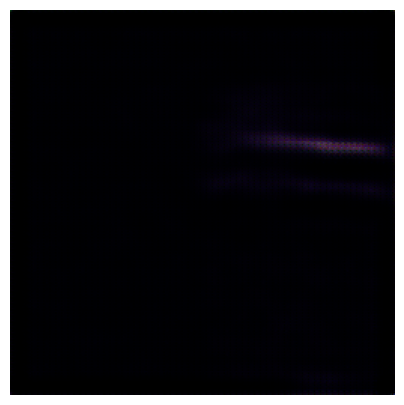

Epoch 282/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.08e+4]


Epoch [282/300] Average Loss: 660.4807


Epoch 283/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.81e+4]


Epoch [283/300] Average Loss: 658.5782


Epoch 284/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.74e+4]


Epoch [284/300] Average Loss: 660.9658


Epoch 285/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.96e+4]


Epoch [285/300] Average Loss: 661.4480


Epoch 286/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.65e+4]


Epoch [286/300] Average Loss: 663.8644


Epoch 287/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.67e+4]


Epoch [287/300] Average Loss: 671.8875


Epoch 288/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.93e+4]


Epoch [288/300] Average Loss: 662.5679


Epoch 289/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=2.1e+4] 


Epoch [289/300] Average Loss: 655.3199


Epoch 290/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.1e+4] 


Epoch [290/300] Average Loss: 656.2599


Epoch 291/300: 100%|██████████| 8/8 [00:15<00:00,  1.94s/it, Loss=1.78e+4]


Epoch [291/300] Average Loss: 662.5186


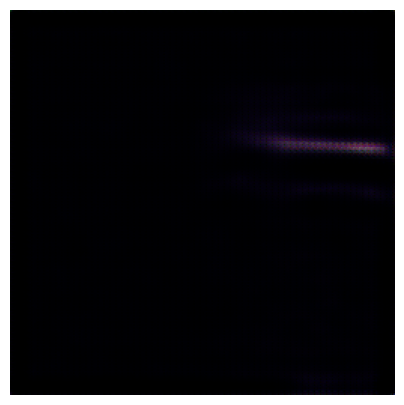

Epoch 292/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.77e+4]


Epoch [292/300] Average Loss: 654.8285


Epoch 293/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.76e+4]


Epoch [293/300] Average Loss: 655.6826


Epoch 294/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=2.02e+4]


Epoch [294/300] Average Loss: 655.8427


Epoch 295/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=2.07e+4]


Epoch [295/300] Average Loss: 655.8283


Epoch 296/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.86e+4]


Epoch [296/300] Average Loss: 648.9417


Epoch 297/300: 100%|██████████| 8/8 [00:15<00:00,  1.97s/it, Loss=1.97e+4]


Epoch [297/300] Average Loss: 647.8694


Epoch 298/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.86e+4]


Epoch [298/300] Average Loss: 646.4029


Epoch 299/300: 100%|██████████| 8/8 [00:15<00:00,  1.96s/it, Loss=1.94e+4]


Epoch [299/300] Average Loss: 651.1700


Epoch 300/300: 100%|██████████| 8/8 [00:15<00:00,  1.95s/it, Loss=1.75e+4]

Epoch [300/300] Average Loss: 647.5347


In [61]:
# Training Loop
for epoch in range(vae_config["NUM_EPOCHS"]):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(lance_train_loader), total=len(lance_train_loader), desc=f'Epoch {epoch+1}/{vae_config["NUM_EPOCHS"]}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(lance_train_loader.dataset)
    loss_array = np.append(loss_array, avg_loss)
    print(f'Epoch [{epoch + 1}/{vae_config["NUM_EPOCHS"]}] Average Loss: {avg_loss:.4f}')

    # show and display a sample of the reconstructed images
    if epoch % 10 == 0:
        with torch.no_grad():
            recon_image, _, _ = model(train_image.to(device))
            draw_image(recon_image.cpu(), save_image = True, epoch=epoch, path = "training_images", outfile_name = "spec_1")


### Save loss array to .npy

In [62]:
training_filepath = training_filepath.split('/')[0]
# Save the loss array to a .npy file in output_data folder
save_loss_array(loss_array, folder="output_data", filename= training_filepath +".npy")

### Plotting the loss function of the training

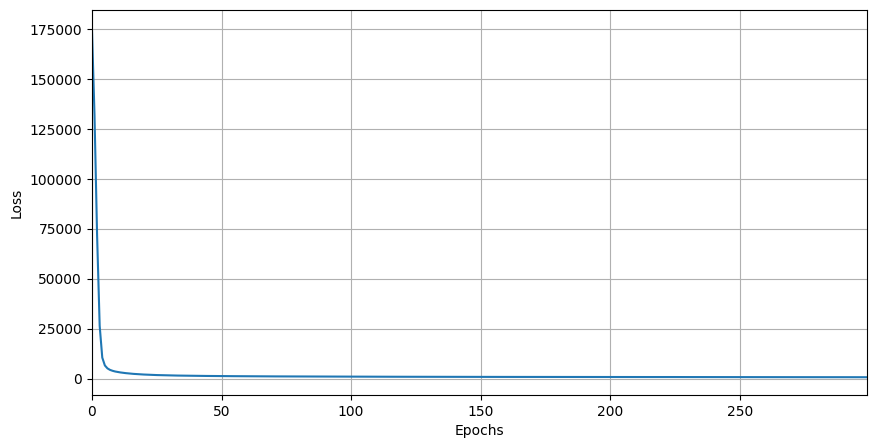

In [63]:
plot_loss(loss_array)

### Compare convergence

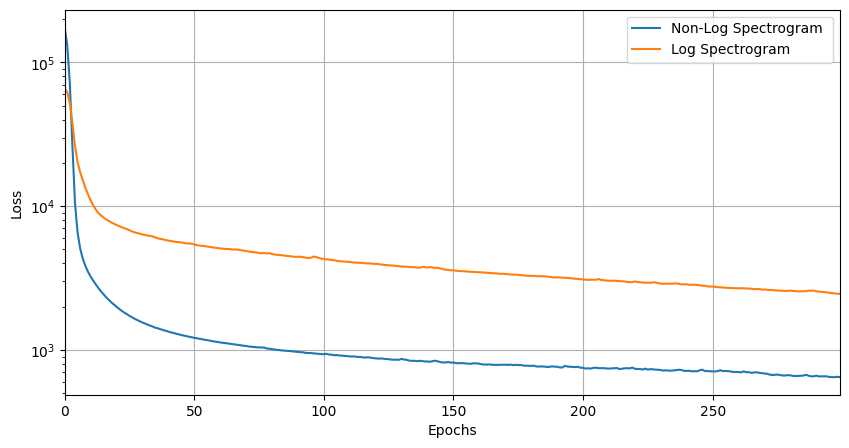

In [72]:
loss_arrays = (np.load("output_data/cat-spectrograms-1.npy"), np.load("output_data/cat-spectrograms-2.npy"))

plot_loss_multiple(loss_arrays, labels=("Non-Log Spectrogram ", "Log Spectrogram"))

### The Reconstructed Images

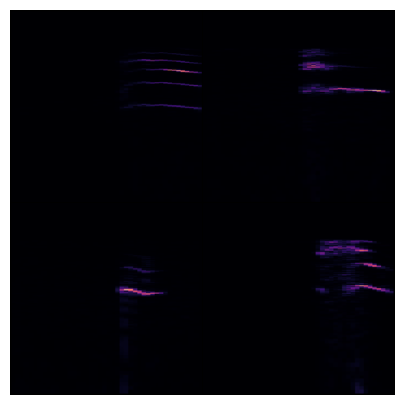

In [64]:
images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

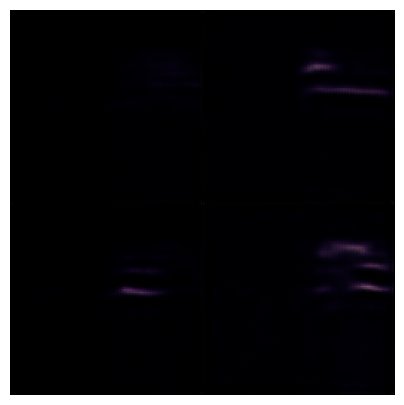

In [65]:
with torch.no_grad():
    recon_images, _, _ = model(images.to(device))
draw_image_grid(recon_images.cpu())

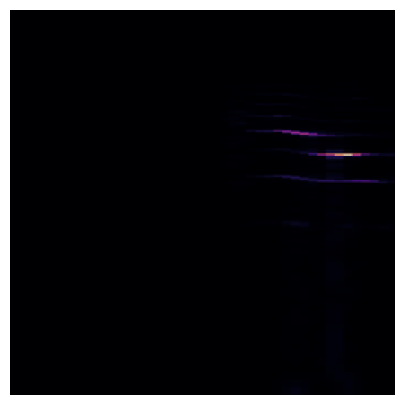

In [66]:
image, _ = next(iter(lance_train_loader))
draw_image(image, save_image=True, path="reconstructedImages", outfile_name="original_5")

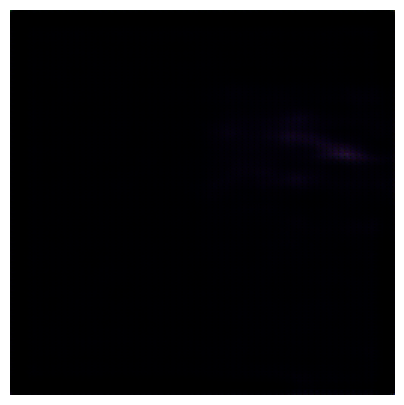

In [67]:
with torch.no_grad():
    recon_image, _, _ = model(image.to(device))
draw_image(recon_image.cpu(), save_image=True, path="reconstructedImages", outfile_name="recon_5")